### Initialization, getting the data

In [1]:
import torch
import pickle
import numpy as np
import random
random.seed(239)
torch.manual_seed(239)
np.random.seed(239)

In [2]:
!wget ennucore.com/f/spectra.npz

Prepended http:// to 'ennucore.com/f/spectra.npz'
--2025-01-22 13:58:23--  http://ennucore.com/f/spectra.npz
Resolving ennucore.com (ennucore.com)... 65.108.246.177
connected. to ennucore.com (ennucore.com)|65.108.246.177|:80... 
308 Permanent Redirectiting response... 
Location: https://ennucore.com/f/spectra.npz [following]
--2025-01-22 13:58:23--  https://ennucore.com/f/spectra.npz
connected. to ennucore.com (ennucore.com)|65.108.246.177|:443... 
HTTP request sent, awaiting response... 200 OK
Length: 104141050 (99M)
Saving to: ‘spectra.npz.2’

spectra.npz.2       100%[===================>]  99.32M  36.1MB/s    in 2.7s    

2025-01-22 13:58:26 (36.1 MB/s) - ‘spectra.npz.2’ saved [104141050/104141050]



In [3]:
spectra = np.load('spectra.npz')
sp620_raw, sp730_raw, labels620, labels730 = spectra['spectra_620'], spectra['spectra_730'], spectra['structures_620'], spectra['structures_730']
sp620_raw.shape, sp730_raw.shape, len(set(labels620))

((6400, 1024), (6300, 1024), 1500)

In [4]:
np.max(labels620)

np.float64(1499.0)

In [5]:
from scipy.signal import savgol_filter

# Define a function to apply the savgol filter to each spectrum
def apply_savgol_filter(data_array):
    filtered_data_array = []
    for spectra in data_array:
        filtered_spectra = [savgol_filter(spectrum, 15, 2) for spectrum in spectra]  # window size 5, polynomial order 2
        filtered_data_array.append(filtered_spectra)
    return np.array(filtered_data_array, dtype=object)

In [6]:
test_structures = np.arange(0, 1500, 15)
labels620_test = labels620[np.where(np.isin(labels620, test_structures))[0]]
labels620_train = labels620[np.where(1 - np.isin(labels620, test_structures))[0]]
sp620_test = sp620_raw[np.where(np.isin(labels620, test_structures))[0]]
sp620_train = sp620_raw[np.where(1 - np.isin(labels620, test_structures))[0]]
labels730_test = labels730[np.where(np.isin(labels730, test_structures))[0]]
labels730_train = labels730[np.where(1 - np.isin(labels730, test_structures))[0]]
sp730_test = sp730_raw[np.where(np.isin(labels730, test_structures))[0]]
sp730_train = sp730_raw[np.where(1 - np.isin(labels730, test_structures))[0]]
from sklearn.model_selection import train_test_split

# Splitting sp620 data into train and validation
sp620_train, sp620_val, labels620_train, labels620_val = train_test_split(
    sp620_train, labels620_train, test_size=0.07, random_state=42)

# Splitting sp730 data into train and validation
sp730_train, sp730_val, labels730_train, labels730_val = train_test_split(
    sp730_train, labels730_train, test_size=0.07, random_state=42)

labels620_test.shape, labels620_train.shape, sp620_train.shape, sp620_val.shape

((430,), (5552,), (5552, 1024), (418, 1024))

In [7]:
def recombine(left, right, left_labels, right_labels):
  N = 0
  for i in range(len(left)):
    for j in range(len(right)):
      if left_labels[i] == right_labels[j]:
        N += 1
  combined = np.zeros((N, 2048))
  combined_labels = np.zeros(N)
  k = 0
  for i in range(len(left)):
    for j in range(len(right)):
      if left_labels[i] == right_labels[j]:
        combined[k] = np.concatenate((left[i], right[j]))
        combined_labels[k] = left_labels[i]
        k += 1
  return combined, combined_labels

In [8]:
train_x, train_y = recombine(sp620_train, sp730_train, labels620_train, labels730_train)
val_x, val_y = recombine(sp620_val, sp730_val, labels620_val, labels730_val)
test_x, test_y = recombine(sp620_test, sp730_test, labels620_test, labels730_test)

In [9]:
# np.savez('combined.npz', train_x=train_x, train_y=train_y, val_x=val_x, val_y=val_y, )

In [10]:
train_x.shape

(25290, 2048)

### Augmenting the data and generating triplet batches

In [11]:
import torch
device = 'mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
def augment_spectrum(spectrum):
    assert len(spectrum) == 2048, "Input spectrum should have 2048 elements."

    # Normalize the original spectrum
    spectrum_norm = spectrum
    transformed = np.array(spectrum_norm)

    # Fourier Transform and normalize
    fourier_first_half = np.fft.fft(savgol_filter(spectrum[:1024], 15, 2)).real
    fourier_second_half = np.fft.fft(savgol_filter(spectrum[1024:], 15, 2)).real
    fourier_first_half_norm = fourier_first_half
    fourier_second_half_norm = fourier_second_half

    transformed = np.concatenate((transformed, fourier_first_half_norm, fourier_second_half_norm))

    # Logarithms and normalize
    log_values = np.log(np.abs(spectrum) + 1)  # Adding a small constant to avoid log(0)
    log_values_norm = log_values
    transformed = np.concatenate((transformed, log_values_norm))

    # Percentage calculations
    perc_first_half = lambda f: np.sum(spectrum[:1024] > f * np.max(spectrum[:1024])) / 1024
    perc_second_half = lambda f: np.sum(spectrum[1024:] > f * np.max(spectrum[1024:])) / 1024
    transformed = np.concatenate((transformed, [perc_first_half(0.5), perc_second_half(0.5), perc_first_half(0.2), perc_second_half(0.2), perc_first_half(0.8), perc_second_half(0.8)]))

    return transformed

In [13]:
X_train, y_train = torch.Tensor(np.array([augment_spectrum(sp) for sp in train_x])).to(device), torch.Tensor(train_y).to(device)
X_val, y_val = torch.Tensor(np.array([augment_spectrum(sp) for sp in val_x])).to(device), torch.Tensor(val_y).to(device)
X_test, y_test = torch.Tensor(np.array([augment_spectrum(sp) for sp in test_x])).to(device), torch.Tensor(test_y).to(device)

In [14]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

(torch.Size([25290, 6150]),
 torch.Size([25290]),
 torch.Size([191, 6150]),
 torch.Size([191]),
 torch.Size([2148, 6150]),
 torch.Size([2148]))

In [15]:
def get_triplet_batch(batch_size, x_all=X_train, y_all=y_train):
    """
    Further optimized function to generate a batch for triplet loss training,
    with checks to handle edge cases where the anchor may be the only example of its class.
    """
    # Calculate positive and negative indices for each class
    labels_unique = torch.unique(y_all)
    positive_indices = {}
    negative_indices = {}
    for label in labels_unique:
        pos_indices = (y_all == label).nonzero(as_tuple=True)[0]
        neg_indices = (y_all != label).nonzero(as_tuple=True)[0]
        if len(pos_indices) > 1:
            positive_indices[label.item()] = pos_indices
        negative_indices[label.item()] = neg_indices

    # Sample batch_size anchors at once
    anchor_indices = torch.randint(0, x_all.shape[0], (batch_size,))
    anchors = x_all[anchor_indices]
    anchor_labels = y_all[anchor_indices]

    # Initialize placeholders for positives and negatives
    positives = torch.zeros_like(anchors)
    negatives = torch.zeros_like(anchors)

    for i, anchor_idx in enumerate(anchor_indices):
        anchor_label = anchor_labels[i].item()

        # Handle the case where the anchor might be the only example of its class
        if len(positive_indices.get(anchor_label, [])) > 1:
            # Exclude the anchor index
            pos_indices = positive_indices[anchor_label]
            pos_indices = pos_indices[pos_indices != anchor_idx]
            positive_idx = pos_indices[torch.randint(0, len(pos_indices), (1,))]
            positives[i] = x_all[positive_idx]
        else:
            # This is a workaround: if there's only one example, use the anchor as positive
            # In a real scenario, you might want to handle this differently
            positives[i] = anchors[i]

        # Sample negatives from different labels
        neg_indices = negative_indices[anchor_label]
        negative_idx = neg_indices[torch.randint(0, len(neg_indices), (1,))]
        negatives[i] = x_all[negative_idx]

    # Transfer tensors to the device
    return anchors.to(device), positives.to(device), negatives.to(device)


In [16]:
X_train.shape, train_x.shape

(torch.Size([25290, 6150]), (25290, 2048))

In [17]:
X_train[1], y_train[1], torch.max(y_train)

(tensor([39.0000, 29.0000, 24.0000,  ...,  0.9990,  0.3271,  0.2959],
        device='mps:0'),
 tensor(927., device='mps:0'),
 tensor(1499., device='mps:0'))

In [18]:
get_triplet_batch(1)

(tensor([[40.0000, 42.0000, 38.0000,  ...,  0.9980,  0.2295,  0.1367]],
        device='mps:0'),
 tensor([[52.0000, 44.0000, 46.0000,  ...,  0.9990,  0.0879,  0.2207]],
        device='mps:0'),
 tensor([[15.0000, 21.0000, 13.0000,  ...,  0.9990,  0.0596,  0.0801]],
        device='mps:0'))

## Functions for testing

In [19]:
import numpy as np
from collections import Counter
from scipy.spatial import distance

def knn_classifier(x_data, y_data, query_points, k=5):
    # Compute the Euclidean distances between all data points and query points
    distances = distance.cdist(query_points, x_data, 'euclidean')
    # Find the indices of the k nearest neighbors for each query point
    nearest_indices = np.argsort(distances, axis=1)[:, :k]
    # Get the labels of the nearest neighbors
    nearest_labels = y_data[nearest_indices]
    # Determine the most common label for each query point
    predicted_labels = []
    for labels in nearest_labels:
        most_common = Counter(labels).most_common(1)
        predicted_labels.append(most_common[0][0])
    return np.array(predicted_labels)

In [20]:
def test_model(model, x_data, y_data, x_data_2=None, y_data_2=None, N=1000):
    if hasattr(model, 'forward_one'):
        model.train(False)
        model = model.forward_one
    if x_data_2 is None:
        selected = np.random.choice(np.arange(len(x_data)), N, replace=False)
        x_data_2, y_data_2 = x_data[selected], y_data[selected]
        excluded = ~np.isin(np.arange(len(x_data)), selected)
        x_data, y_data = x_data[excluded], y_data[excluded]

    with torch.no_grad():
        x_emb = model(x_data).cpu().numpy()
        x2_emb = model(x_data_2).cpu().numpy()
        y_classified = knn_classifier(x_emb, y_data.cpu().numpy(), x2_emb)
    return np.mean(y_classified == y_data_2.cpu().numpy())

In [21]:
test_model(lambda x: x, X_train, y_train, X_val, y_val)

np.float64(0.19895287958115182)

## TripletNet

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim

class TripletNet(nn.Module):
    def __init__(self, input_dim):
        super(TripletNet, self).__init__()
        self.embedding = nn.Sequential(
            nn.BatchNorm1d(input_dim),
            nn.Linear(input_dim, 2048),
            nn.LeakyReLU(),
            nn.BatchNorm1d(2048),
            nn.Linear(2048, 1024),
            # nn.LeakyReLU(),
            # nn.BatchNorm1d(1024),
            # nn.Linear(1024, 512),
            # nn.LeakyReLU(),
            # nn.BatchNorm1d(512),
            # nn.Linear(1024, 512),
        )

    def forward_one(self, x):
        return self.embedding(x)


    def forward(self, anchor, positive, negative):
        anchor_embedding = self.forward_one(anchor)
        positive_embedding = self.forward_one(positive)
        negative_embedding = self.forward_one(negative)
        return anchor_embedding, positive_embedding, negative_embedding

In [23]:
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt

def calculate_rates(x_emb, labels, cutoff):
    # Calculate pairwise distances between all embeddings
    pairwise_dist = distance.squareform(distance.pdist(x_emb, 'euclidean'))
    # Determine whether pairs are of the same class
    same_class = labels[:, None] == labels[None, :]
    # Determine which pairs are below the cutoff distance
    within_cutoff = pairwise_dist < cutoff

    # True Positives (TP): Same class and within cutoff
    TP = np.sum(within_cutoff & same_class)
    # False Positives (FP): Different class but within cutoff
    FP = np.sum(within_cutoff & ~same_class)
    # False Negatives (FN): Same class but above cutoff
    FN = np.sum(~within_cutoff & same_class)
    # True Negatives (TN): Different class and above cutoff
    TN = np.sum(~within_cutoff & ~same_class)

    # Calculate rates
    TPR = TP / (TP + FN) if TP + FN > 0 else 0  # True Positive Rate
    FPR = FP / (FP + TN) if FP + TN > 0 else 0  # False Positive Rate
    FNR = FN / (TP + FN) if TP + FN > 0 else 0  # False Negative Rate

    return TPR, FPR, FNR

def plot_rates(x_emb, labels, distances, postfix='', filename=''):
    TPRs, FPRs, FNRs, TNRs, accs = [], [], [], [], []
    pairwise_dist = distance.squareform(distance.pdist(x_emb, 'euclidean'))
    for cutoff in distances:
        # print(cutoff)
        same_class = labels[:, None] == labels[None, :]
        # Determine which pairs are below the cutoff distance
        within_cutoff = pairwise_dist < cutoff

        # True Positives (TP): Same class and within cutoff
        TP = np.sum(within_cutoff & same_class)
        # False Positives (FP): Different class but within cutoff
        FP = np.sum(within_cutoff & ~same_class)
        # False Negatives (FN): Same class but above cutoff
        FN = np.sum(~within_cutoff & same_class)
        # True Negatives (TN): Different class and above cutoff
        TN = np.sum(~within_cutoff & ~same_class)

        # Calculate rates
        TPR = TP / (TP + FN) if TP + FN > 0 else 0  # True Positive Rate
        FPR = FP / (FP + TN) if FP + TN > 0 else 0  # False Positive Rate
        FNR = FN / (TP + FN) if TP + FN > 0 else 0  # False Negative Rate
        TNR = TN / (TN + FP) if TN + FP > 0 else 0
        acc = (TPR + TNR) / 2
        accs.append(acc)

        TPRs.append(TPR)
        FPRs.append(FPR)
        FNRs.append(FNR)
        TNRs.append(TNR)

    if any(tpr > 0.95 for tpr in TPRs):
        print('FPR@tpr=0.95')
        ind = [i for i, tpr in enumerate(TPRs) if tpr > 0.95][0]
        print(FPRs[ind], f'(d={distances[ind]})')
        print(f'acc@tpr=0.95 is {accs[ind]}')
        print()
    acc_cutoff = 0.965
    if any(acc > acc_cutoff for acc in accs):
        print(f'FPR@acc={acc_cutoff}')
        ind = [i for i, acc in enumerate(accs) if acc > acc_cutoff][0]
        print(FPRs[ind], f'(d={distances[ind]})')
        print()
    max_acc_key = max(range(len(accs)), key=lambda i: accs[i])
    print(f'Max accuracy: {max(accs)} for cutoff distance {distances[max_acc_key]}, FPR={FPRs[max_acc_key]}')
    plt.figure(figsize=(10,6))
    plt.plot(distances, TPRs, label='True Positive Rate (Correct Validation)')
    plt.plot(distances, FPRs, label='False Positive Rate')
    plt.plot(distances, FNRs, label='False Negative Rate')
    plt.plot(distances, TNRs, label='True Negative Rate')
    plt.plot(distances, accs, label='Accuracy')
    plt.title('Rates vs Cutoff Distance' + postfix)
    plt.xlabel('Cutoff Distance')
    plt.ylabel('Rate')
    plt.legend()
    plt.grid(True)
    if filename:
      plt.savefig(filename)
    plt.show()


def get_fpr(x_emb, labels, distances, tpr_cutoff=0.95):
    TPRs, FPRs, FNRs, TNRs = [], [], [], []
    pairwise_dist = distance.squareform(distance.pdist(x_emb, 'euclidean'))
    for cutoff in distances:
        # print(cutoff)
        same_class = labels[:, None] == labels[None, :]
        # Determine which pairs are below the cutoff distance
        within_cutoff = pairwise_dist < cutoff

        # True Positives (TP): Same class and within cutoff
        TP = np.sum(within_cutoff & same_class)
        # False Positives (FP): Different class but within cutoff
        FP = np.sum(within_cutoff & ~same_class)
        # False Negatives (FN): Same class but above cutoff
        FN = np.sum(~within_cutoff & same_class)
        # True Negatives (TN): Different class and above cutoff
        TN = np.sum(~within_cutoff & ~same_class)

        # Calculate rates
        TPR = TP / (TP + FN) if TP + FN > 0 else 0  # True Positive Rate
        FPR = FP / (FP + TN) if FP + TN > 0 else 0  # False Positive Rate
        FNR = FN / (TP + FN) if TP + FN > 0 else 0  # False Negative Rate
        TNR = TN / (TN + FP) if TN + FP > 0 else 0
        if TPR > tpr_cutoff:
            return FPR


def get_max_accuracy(x_emb, labels, distances):
    TPRs, FPRs, FNRs, TNRs, accs = [], [], [], [], []
    pairwise_dist = distance.squareform(distance.pdist(x_emb, 'euclidean'))
    for cutoff in distances:
        same_class = labels[:, None] == labels[None, :]
        # Determine which pairs are below the cutoff distance
        within_cutoff = pairwise_dist < cutoff

        # True Positives (TP): Same class and within cutoff
        TP = np.sum(within_cutoff & same_class)
        # False Positives (FP): Different class but within cutoff
        FP = np.sum(within_cutoff & ~same_class)
        # False Negatives (FN): Same class but above cutoff
        FN = np.sum(~within_cutoff & same_class)
        # True Negatives (TN): Different class and above cutoff
        TN = np.sum(~within_cutoff & ~same_class)

        # Calculate rates
        TPR = TP / (TP + FN) if TP + FN > 0 else 0  # True Positive Rate
        FPR = FP / (FP + TN) if FP + TN > 0 else 0  # False Positive Rate
        FNR = FN / (TP + FN) if TP + FN > 0 else 0  # False Negative Rate
        TNR = TN / (TN + FP) if TN + FP > 0 else 0
    print(f'Max accuracy is {max(accs)} at distance {distances[max(range(len(accs)), key=lambda i: accs[i])]}')
    return max(accs)


def get_model_fpr(m):
    with torch.no_grad():
        return get_fpr(model.forward_one(X_val).cpu().numpy(), y_val.cpu().numpy(), np.linspace(5, 100, num=100))

def get_model_max_acc(m):
    with torch.no_grad():
        return get_max_accuracy(model.forward_one(X_val).cpu().numpy(), y_val.cpu().numpy(), np.linspace(5, 100, num=100))

In [24]:
# Initialize the model and loss function
input_dim = 6150
model = TripletNet(input_dim).to(device)
criterion = nn.TripletMarginLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
losses = []
val_losses = []
model_scores = []
model.train(True)

# Training settings
num_epochs = 50
batch_size = 1024

for epoch in range(num_epochs):
    for _ in range(len(X_train) // (3*batch_size)):
        # Generate a triplet batch
        anchor, positive, negative = get_triplet_batch(batch_size)
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

        # Forward pass
        anchor_embedding, positive_embedding, negative_embedding = model(anchor, positive, negative)

        # Compute the loss
        loss = criterion(anchor_embedding, positive_embedding, negative_embedding)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    l = loss.item()
    losses.append(l)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {l:.4f}")
    with torch.no_grad():
        anchor, positive, negative = get_triplet_batch(batch_size * 10, X_val, y_val)
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
        anchor_embedding, positive_embedding, negative_embedding = model(anchor, positive, negative)
        val_l = criterion(anchor_embedding, positive_embedding, negative_embedding)
        val_losses.append(val_l)
        model_scores.append(test_model(model, X_train, y_train, X_val, y_val))
        print(f'Val loss: {val_l:.4f}')
    print(f'FPR: {get_model_fpr(model)}')


Epoch [1/50], Loss: 0.0989
Val loss: 0.0369
FPR: 0.10349030470914128
Epoch [2/50], Loss: 0.2377
Val loss: 0.0238
FPR: 0.06537396121883657
Epoch [3/50], Loss: 0.1295
Val loss: 0.0177
FPR: 0.04598337950138504
Epoch [4/50], Loss: 0.0857
Val loss: 0.0204
FPR: 0.07168975069252077
Epoch [5/50], Loss: 0.0658
Val loss: 0.0128
FPR: 0.04565096952908587
Epoch [6/50], Loss: 0.0830
Val loss: 0.0227
FPR: 0.050858725761772854
Epoch [7/50], Loss: 0.0734
Val loss: 0.0130
FPR: 0.03623268698060942
Epoch [8/50], Loss: 0.0686
Val loss: 0.0142
FPR: 0.027313019390581717
Epoch [9/50], Loss: 0.0330
Val loss: 0.0113
FPR: 0.03750692520775623
Epoch [10/50], Loss: 0.0702
Val loss: 0.0090
FPR: 0.026094182825484764
Epoch [11/50], Loss: 0.0821
Val loss: 0.0251
FPR: 0.03606648199445983
Epoch [12/50], Loss: 0.0842
Val loss: 0.0111
FPR: 0.03545706371191136
Epoch [13/50], Loss: 0.1618
Val loss: 0.0162
FPR: 0.02332409972299169
Epoch [14/50], Loss: 0.0771
Val loss: 0.0143
FPR: 0.033961218836565096
Epoch [15/50], Loss: 0.07

In [25]:
def label_matrix(labels):
    n = len(labels)
    matrix = torch.zeros((n, n))

    for i in range(n):
        for j in range(i+1, n):
            if labels[i] != labels[j]:
                matrix[i][j] = 1
                matrix[j][i] = 1
    return matrix

def get_indices_for_label(label, n):
    indices = torch.nonzero(y_train == label).squeeze(1)
    n_samples = min(len(indices), n)
    random_indices = torch.randint(low=0, high=len(indices), size=(n_samples,))
    return indices[random_indices]

def batch_loss(batch_indices):
    batch_x = X_train[batch_indices].to(device)
    batch_y = y_train[batch_indices].to(device)
    emb_b_x = model.forward_one(batch_x)
    distances = torch.cdist(emb_b_x, emb_b_x)
    vals = (torch.sigmoid(5 * distances / torch.mean(distances)) - 0.5)*2
    return torch.mean((vals - label_matrix(batch_y).to(device))**2)


def get_batch_indices():
    n_samples = 40
    labels = y_train[torch.randint(0, len(y_train), (n_samples,))]
    return torch.concatenate(tuple(get_indices_for_label(l, torch.randint(1, 5, tuple())) for l in labels))

In [26]:
# Initialize the model and loss function
input_dim = 6150
model = TripletNet(input_dim).to(device)
criterion = nn.TripletMarginLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
losses = []
val_losses = []
model_scores = []
fprs_during_training = []
model.train(True)

# Training settings
num_epochs = 13
batch_size = 500

for epoch in range(num_epochs):
    for _ in range(len(X_train) // (batch_size)):
        loss = batch_loss(get_batch_indices())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    l = loss.item()
    losses.append(l)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {l:.4f}")
    with torch.no_grad():
        anchor, positive, negative = get_triplet_batch(batch_size * 10, X_val, y_val)
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
        anchor_embedding, positive_embedding, negative_embedding = model(anchor, positive, negative)
        val_l = criterion(anchor_embedding, positive_embedding, negative_embedding)
        val_losses.append(val_l)
        model_scores.append(test_model(model, X_train, y_train, X_val, y_val))
        print(f'Val loss: {val_l:.4f}')
    current_fpr = get_model_fpr(model)
    fprs_during_training.append(current_fpr)
    print(f'FPR: {current_fpr}')


Epoch [1/13], Loss: 0.0108
Val loss: 0.0150
FPR: 0.06692520775623269
Epoch [2/13], Loss: 0.0105
Val loss: 0.0263
FPR: 0.04155124653739612
Epoch [3/13], Loss: 0.0096
Val loss: 0.0064
FPR: 0.017506925207756232
Epoch [4/13], Loss: 0.0080
Val loss: 0.0124
FPR: 0.021218836565096953
Epoch [5/13], Loss: 0.0122
Val loss: 0.0073
FPR: 0.021606648199445983
Epoch [6/13], Loss: 0.0077
Val loss: 0.0096
FPR: 0.018836565096952907
Epoch [7/13], Loss: 0.0084
Val loss: 0.0136
FPR: 0.020277008310249308
Epoch [8/13], Loss: 0.0090
Val loss: 0.0106
FPR: 0.012520775623268698
Epoch [9/13], Loss: 0.0086
Val loss: 0.0103
FPR: 0.01772853185595568
Epoch [10/13], Loss: 0.0078
Val loss: 0.0135
FPR: 0.012908587257617728
Epoch [11/13], Loss: 0.0092
Val loss: 0.0188
FPR: 0.018614958448753462
Epoch [12/13], Loss: 0.0070
Val loss: 0.0071
FPR: 0.019556786703601108
Epoch [13/13], Loss: 0.0096
Val loss: 0.0085
FPR: 0.009861495844875346


In [27]:
for epoch in range(num_epochs):
    for _ in range(len(X_train) // (batch_size)):
        loss = batch_loss(get_batch_indices())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    l = loss.item()
    losses.append(l)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {l:.4f}")
    with torch.no_grad():
        anchor, positive, negative = get_triplet_batch(batch_size * 10, X_val, y_val)
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
        anchor_embedding, positive_embedding, negative_embedding = model(anchor, positive, negative)
        val_l = criterion(anchor_embedding, positive_embedding, negative_embedding)
        val_losses.append(val_l)
        model_scores.append(test_model(model, X_train, y_train, X_val, y_val))
        print(f'Val loss: {val_l:.4f}')
    current_fpr = get_model_fpr(model)
    fprs_during_training.append(current_fpr)
    print(f'FPR: {current_fpr}')

Epoch [1/13], Loss: 0.0065
Val loss: 0.0196
FPR: 0.015678670360110804
Epoch [2/13], Loss: 0.0074
Val loss: 0.0128
FPR: 0.014515235457063711
Epoch [3/13], Loss: 0.0084
Val loss: 0.0115
FPR: 0.015789473684210527
Epoch [4/13], Loss: 0.0065
Val loss: 0.0239
FPR: 0.01601108033240997
Epoch [5/13], Loss: 0.0071
Val loss: 0.0316
FPR: 0.012520775623268698
Epoch [6/13], Loss: 0.0061
Val loss: 0.0069
FPR: 0.012797783933518006
Epoch [7/13], Loss: 0.0065
Val loss: 0.0080
FPR: 0.012742382271468145
Epoch [8/13], Loss: 0.0056
Val loss: 0.0106
FPR: 0.010914127423822714
Epoch [9/13], Loss: 0.0074
Val loss: 0.0228
FPR: 0.015789473684210527
Epoch [10/13], Loss: 0.0062
Val loss: 0.0216
FPR: 0.013240997229916897
Epoch [11/13], Loss: 0.0065
Val loss: 0.0215
FPR: 0.012409972299168974
Epoch [12/13], Loss: 0.0053
Val loss: 0.0314
FPR: 0.012132963988919667
Epoch [13/13], Loss: 0.0061
Val loss: 0.0136
FPR: 0.011745152354570637


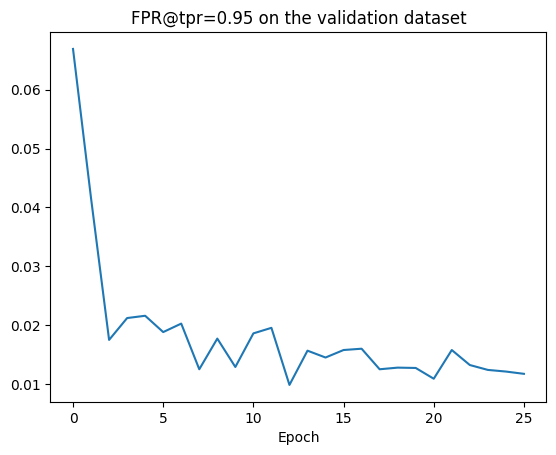

In [28]:
plt.plot(fprs_during_training)
plt.title("FPR@tpr=0.95 on the validation dataset")
plt.xlabel("Epoch")
plt.savefig('class_rate.svg')

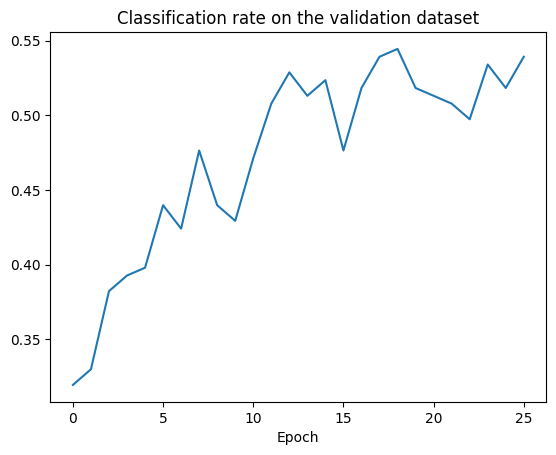

In [29]:
from matplotlib import pyplot as plt
plt.plot(model_scores)
plt.title("Classification rate on the validation dataset")
plt.xlabel("Epoch")
plt.savefig('class_rate.svg')

In [30]:
test_model(model, X_train, y_train, X_val, y_val)

np.float64(0.5392670157068062)

In [31]:
test_model(lambda x: x, X_test, y_test, N=400), test_model(model, X_test, y_test, N=400)

(np.float64(0.87), np.float64(0.9475))

In [32]:

# distances = np.linspace(0, 10, num=60)
# with torch.no_grad():
#   plot_rates(model.forward_one(X_train).cpu().numpy(), y_train.cpu().numpy(), distances, ": previously seen spectra", "confusion-train.svg")


In [33]:
with torch.no_grad():
  test_embeddings = model.forward_one(X_test).cpu().numpy()
print(np.max(test_embeddings))
print(test_embeddings.shape)
print(np.min(test_embeddings))

17.933462
(2148, 1024)
-16.438345


In [34]:
get_model_fpr(model)

np.float64(0.011745152354570637)

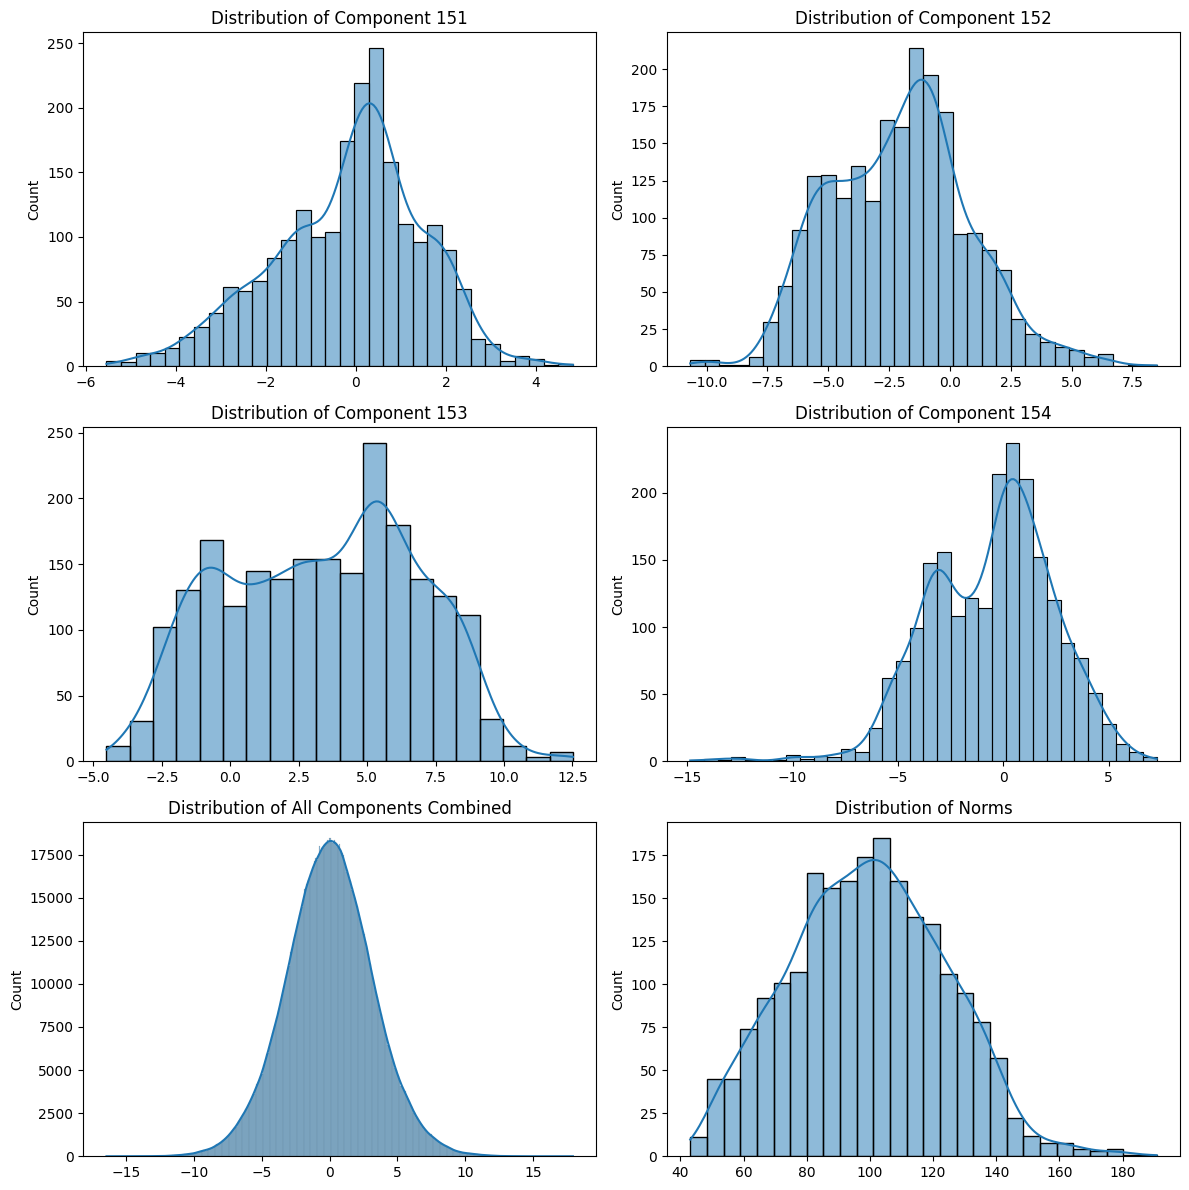

In [35]:
import seaborn as sns

with torch.no_grad():
    res = model.forward_one(X_test).cpu().numpy()
    # sns.distplot(res[:, 151])
    # 1. Define the figure and axes for 6 subplots (4 components + 1 for .ravel() + 1 for norms)
    fig, axes = plt.subplots(3, 2, figsize=(12, 12))  # Adjust size as needed
    axes = axes.ravel()

    # 2. Plot distributions for 4 specific components
    components = [151, 152, 153, 154]  # Just an example, replace with your components of interest
    for i, comp in enumerate(components):
        sns.histplot(res[:, comp], ax=axes[i], kde=True)  # Using histplot instead of distplot
        axes[i].set_title(f'Distribution of Component {comp}')

    # 3. Plot distribution for all components combined (.ravel())
    sns.histplot(res.ravel(), ax=axes[4], kde=True)
    axes[4].set_title('Distribution of All Components Combined')

    # 4. Calculate and plot the distribution of the norms of each row
    norms = np.linalg.norm(res, axis=1)
    sns.histplot(norms, ax=axes[5], kde=True)
    axes[5].set_title('Distribution of Norms')

    plt.tight_layout()
    plt.savefig('some-distributions.svg')
    plt.show()

FPR@tpr=0.95
0.011578947368421053 (d=46.09218436873748)
acc@tpr=0.95 is 0.970588479071695

FPR@acc=0.965
0.0096398891966759 (d=44.28857715430862)

Max accuracy: 0.9835595204339069 for cutoff distance 54.90981963927856, FPR=0.022382271468144043


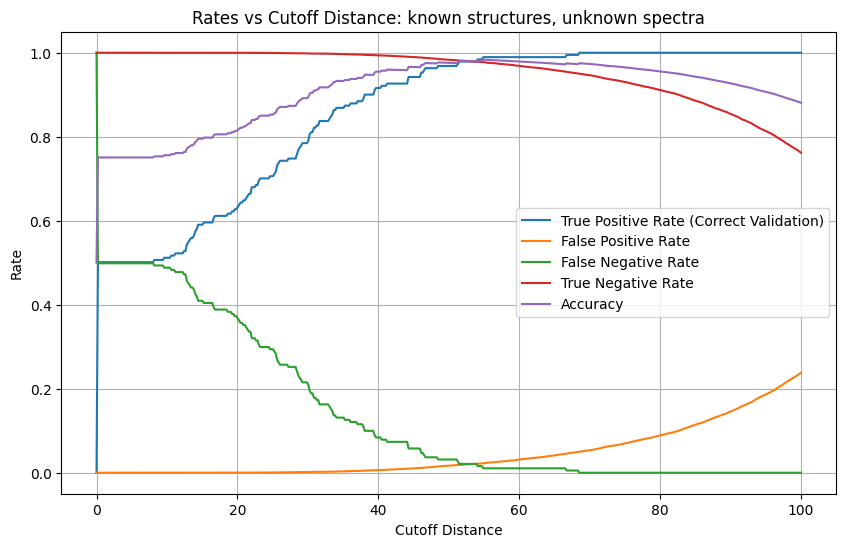

In [36]:
distances = np.linspace(0, 100, num=500)
with torch.no_grad():
  plot_rates(model.forward_one(X_val).cpu().numpy(), y_val.cpu().numpy(), distances, ": known structures, unknown spectra", "confusion-val.svg")

FPR@tpr=0.95
0.019879695742550302 (d=54.30861723446894)
acc@tpr=0.95 is 0.9652314664905788

FPR@acc=0.965
0.019584763109049132 (d=54.10821643286573)

Max accuracy: 0.9693158569039686 for cutoff distance 60.721442885771545, FPR=0.03074584401065996


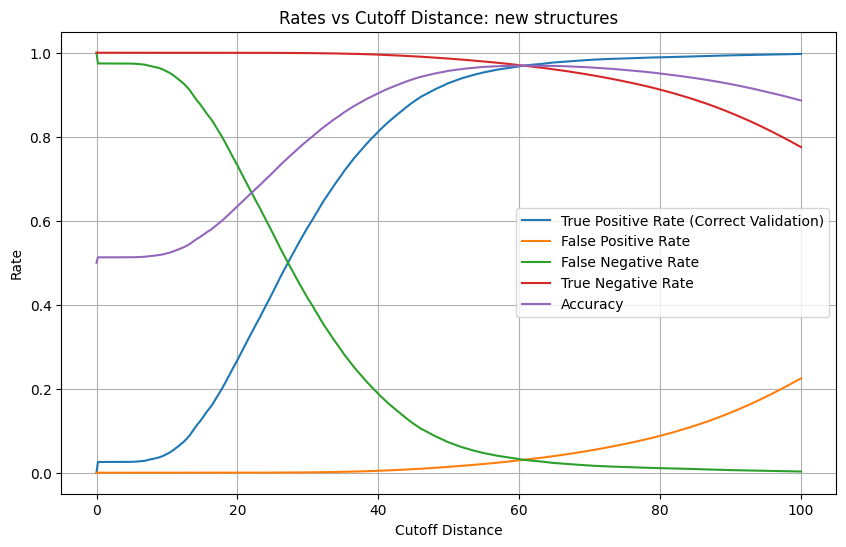

In [37]:
distances = np.linspace(0, 100, num=500)
with torch.no_grad():
  plot_rates(model.forward_one(X_test).cpu().numpy(), y_test.cpu().numpy(), distances, ": new structures", "confusion-test.svg")

In [38]:
# distances = np.linspace(0, 5, num=50)
# with torch.no_grad():
#   plot_rates(X_train.cpu().numpy(), y_train.cpu().numpy(), distances)


(191, 6150)
FPR@tpr=0.95
0.24132963988919667 (d=33165.82914572864)
acc@tpr=0.95 is 0.8557131328113072

Max accuracy: 0.8878734341032856 for cutoff distance 14070.35175879397, FPR=0.07202216066481995


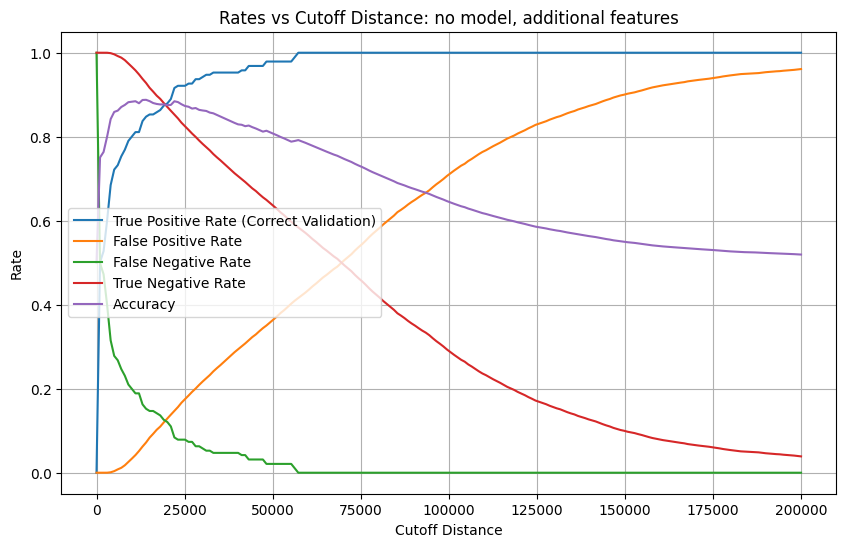

In [39]:
distances = np.linspace(0, 200000, num=200)
print(X_val.cpu().numpy().shape)
with torch.no_grad():
  plot_rates(X_val.cpu().numpy(), y_val.cpu().numpy(), distances, ": no model, additional features", "confusion-nomodel-test.svg")

FPR@tpr=0.95
0.3048753462603878 (d=1497.4874371859298)
acc@tpr=0.95 is 0.8265649515417222

Max accuracy: 0.8969177190801289 for cutoff distance 572.8643216080402, FPR=0.04343490304709141


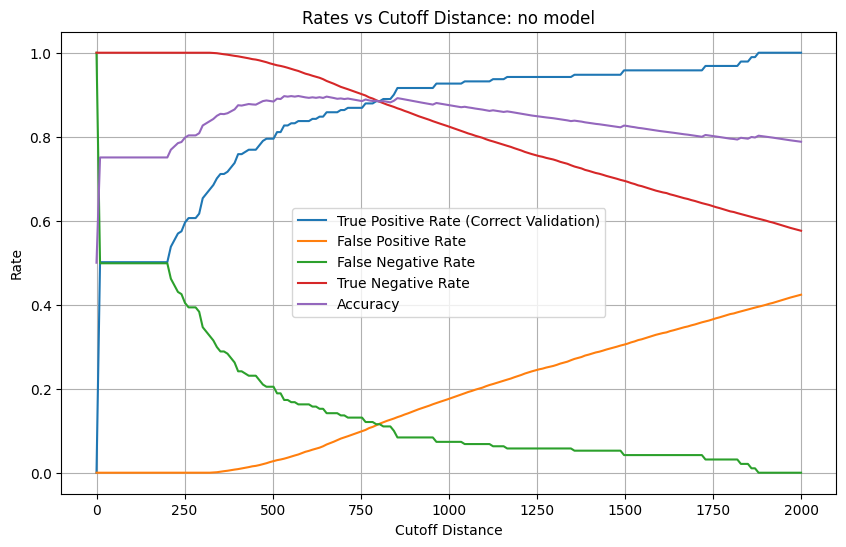

In [40]:
distances = np.linspace(0, 2000, num=200)
with torch.no_grad():
  plot_rates(val_x, val_y, distances, ": no model", "confusion-nomodel-test.svg")

#### Results for different configurations
Baseline model score is 0.136, for triplet with LReLu and 30 epochs and 2048-1024-256-64 it's 0.33. And 0.9375 (vs 0.93 baseline) on the second test

With 512 as the last layer (no 64): 0.36, (0.9175, 0.9475)

/var/folders/1x/t909rs3x6rx12g06tz4zy9740000gn/T/ipykernel_31252/2252215409.py:19: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(same_class_distances, label='Same Structure', shade=True, clip=(0, None))
/var/folders/1x/t909rs3x6rx12g06tz4zy9740000gn/T/ipykernel_31252/2252215409.py:20: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(diff_class_distances, label='Different Structures', shade=True, clip=(0, None))


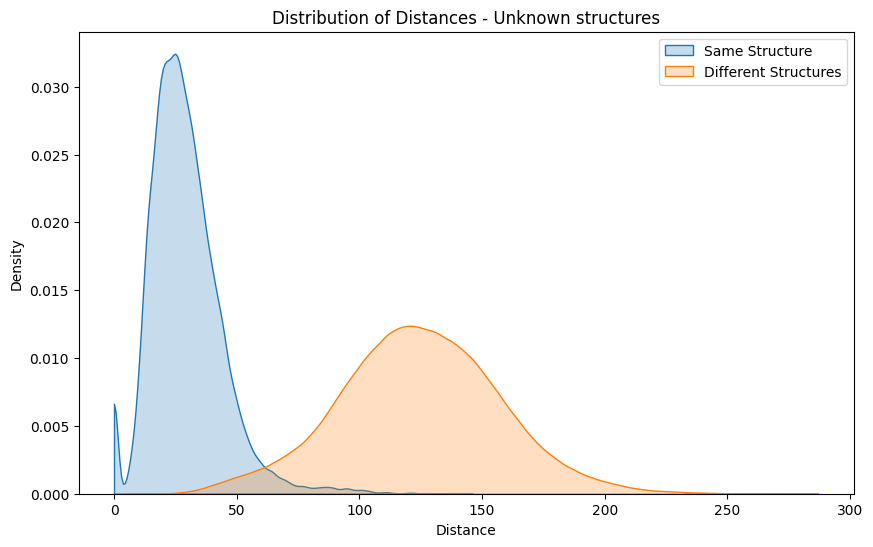

/var/folders/1x/t909rs3x6rx12g06tz4zy9740000gn/T/ipykernel_31252/2252215409.py:19: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(same_class_distances, label='Same Structure', shade=True, clip=(0, None))
/var/folders/1x/t909rs3x6rx12g06tz4zy9740000gn/T/ipykernel_31252/2252215409.py:20: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(diff_class_distances, label='Different Structures', shade=True, clip=(0, None))


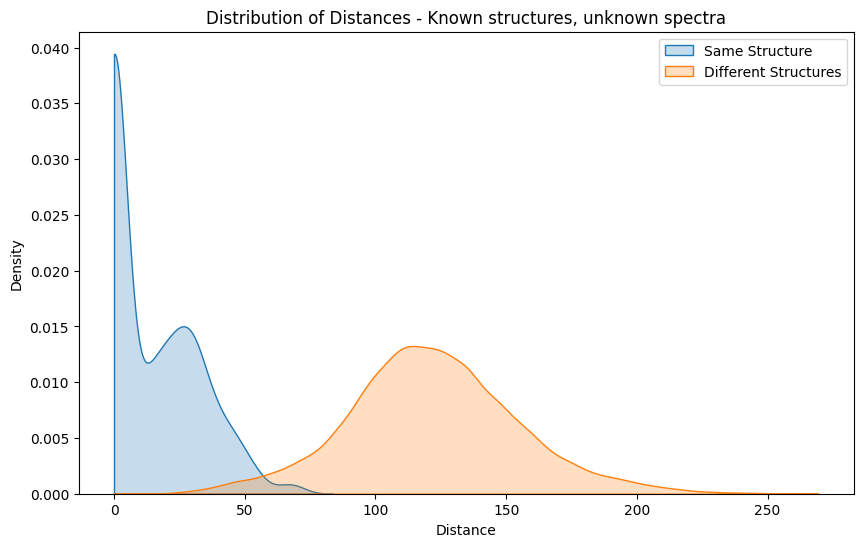

/var/folders/1x/t909rs3x6rx12g06tz4zy9740000gn/T/ipykernel_31252/2252215409.py:19: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(same_class_distances, label='Same Structure', shade=True, clip=(0, None))
/var/folders/1x/t909rs3x6rx12g06tz4zy9740000gn/T/ipykernel_31252/2252215409.py:20: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(diff_class_distances, label='Different Structures', shade=True, clip=(0, None))


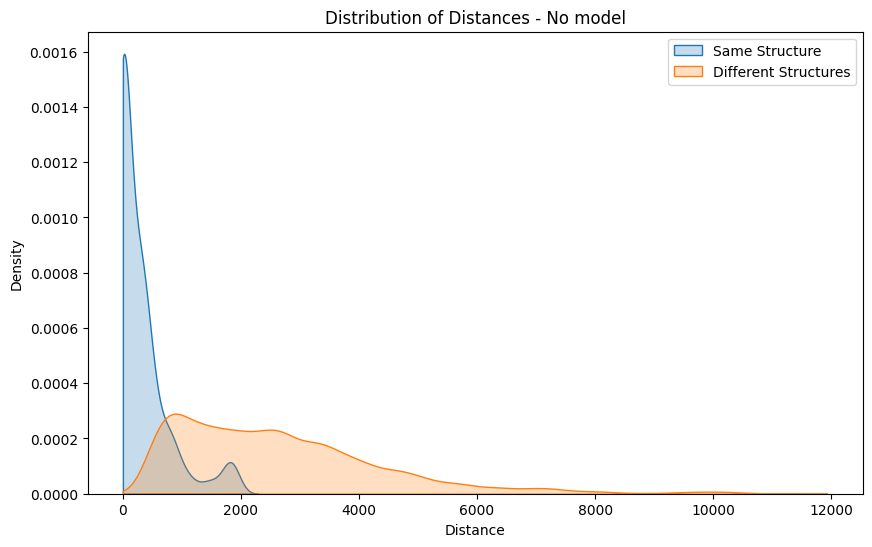

In [41]:
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt
import seaborn as sns

def plot_distance_distributions(x_emb, labels, t_postfix='', filename=''):
    # Calculate pairwise distances between all embeddings
    pairwise_dist = distance.squareform(distance.pdist(x_emb, 'euclidean'))

    # Determine whether pairs are of the same class
    same_class = labels[:, None] == labels[None, :]

    # Extract distances for same class and different class pairs
    same_class_distances = pairwise_dist[same_class]
    diff_class_distances = pairwise_dist[~same_class]

    # Plot the distributions
    plt.figure(figsize=(10, 6))
    sns.kdeplot(same_class_distances, label='Same Structure', shade=True, clip=(0, None))
    sns.kdeplot(diff_class_distances, label='Different Structures', shade=True, clip=(0, None))
    plt.title('Distribution of Distances' + t_postfix)
    plt.xlabel('Distance')
    plt.ylabel('Density')
    plt.legend()
    if filename:
        plt.savefig(filename)
    plt.show()

# Assuming you have the model and X_test, y_test available
with torch.no_grad():
    test_embeddings = model.forward_one(X_test).cpu().numpy()
    plot_distance_distributions(test_embeddings, y_test.cpu().numpy(), ' - Unknown structures', 'distance-distrib.svg')
    val_embeddings = model.forward_one(X_val).cpu().numpy()
    plot_distance_distributions(val_embeddings, y_val.cpu().numpy(), ' - Known structures, unknown spectra', 'distance-distrib-val.svg')
    plot_distance_distributions(val_x, val_y, ' - No model', 'distance-distrib-nomodel.svg')

## Test on different spectra

In [42]:
!ls

Changing_resolution.7z          enthropy.svg
Unclonix 2.ipynb                figures
Unclonix-copy.ipynb             inputs
Unclonix.ipynb                  mat-confusion-20x20-max41.3.svg
class_rate.svg                  model-03.pth
combined.npz                    model.pt
confusion-nomodel-test.svg      poetry.lock
confusion-test.svg              pyproject.toml
confusion-val.svg               some-distributions.svg
data2                           spectra.npz
data2.npz                       spectra.npz.1
distance-distrib-nomodel.svg    spectra.npz.2
distance-distrib-val.svg        spectra_data_combined_final.npz
distance-distrib.svg            xxx.txt
enthropy.pdf


In [43]:
new_spectra = np.load('data2.npz', allow_pickle=True)

In [44]:
new_spectra['data_620'].tolist().keys()

dict_keys(['17x17', '4x4_(3)', '6x6_(3)', '4x4', '8x8', '15x15', '14x14', '13x13', '5x5_(2)', '7x7_(2)', '5x5', '10x10', '9x9', '20x20', '7x7'])

In [45]:
# new_spectra['data_620'].tolist()['8x8'].shape, new_spectra['data_730'].tolist()['4x4_(3)'].shape

In [46]:
new_data_620 = new_spectra['data_620'].tolist()
new_data_730 = new_spectra['data_730'].tolist()

In [47]:
new_data_620['10x10'].shape

(100, 1024)

In [48]:
new_data_combined = {key: np.concatenate((new_data_620[key], new_data_620[key]), axis=1) for key in new_data_620.keys()}

In [49]:
new_data_c = {key: torch.Tensor(np.array([augment_spectrum(sp) for sp in new_data_combined[key]])).to(device) for key in new_data_620.keys()}

In [50]:
with torch.no_grad():
  new_data_emb = {key: model.forward_one(new_data_c[key]).cpu().numpy() for key in new_data_c.keys()}

In [51]:
new_data_emb.keys(), new_data_emb['10x10'].shape

(dict_keys(['17x17', '4x4_(3)', '6x6_(3)', '4x4', '8x8', '15x15', '14x14', '13x13', '5x5_(2)', '7x7_(2)', '5x5', '10x10', '9x9', '20x20', '7x7']),
 (100, 1024))

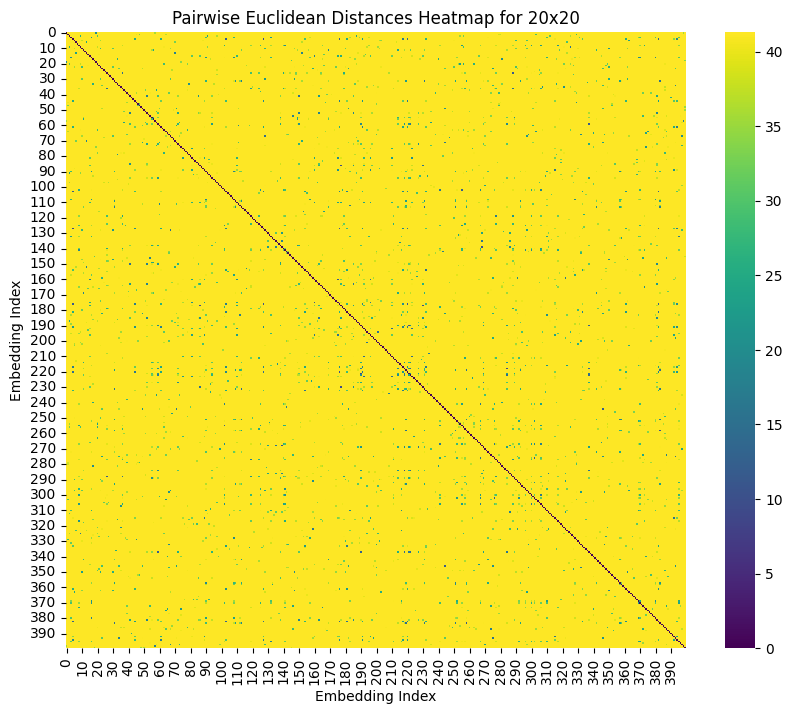

In [52]:
# Re-import necessary libraries after code execution state reset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist

# Since the actual embeddings data `new_data_emb` is not accessible due to reset, we will simulate a similar structure
# for demonstration purposes. This code block should be adapted to load or reference your actual embeddings data.


# Plotting the heatmap of pairwise Euclidean distances between embeddings for demonstration
structure = '20x20'  # Example structure key
embeddings = new_data_emb[structure]  # Example embeddings for this structure

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Calculating pairwise Euclidean distances between embeddings
distances = cdist(embeddings, embeddings, 'euclidean')

# Creating the heatmap
plt.figure(figsize=(10, 8))
vmax=41.3   # 32.2
sns.heatmap(distances, cmap="viridis", vmax=vmax)
plt.title(f'Pairwise Euclidean Distances Heatmap for {structure}')
plt.xlabel('Embedding Index')
plt.ylabel('Embedding Index')

plt.savefig(f'mat-confusion-{structure}-max{vmax}.svg')
plt.show()


## Save the model

In [53]:
# save the model
torch.save(model.state_dict(), 'model.pt')

In [54]:
import numpy as np

def continuous_entropy(data, num_bins=50):
    """
    Estimate the continuous entropy of a 1D distribution using a histogram approximation.
    Entropy is estimated as H(X) = -∑ p(x)*log2(p(x)) over histogram bins.
    
    Parameters:
    data: 1D array of samples from the distribution.
    num_bins: Number of bins for the histogram.
    
    Returns:
    entropy_est: Estimated entropy in bits.
    """
    # Compute histogram
    hist, bin_edges = np.histogram(data, bins=num_bins, density=True)
    # Remove zeros to avoid log issues
    hist = hist[hist > 0]
    # Compute entropy
    entropy_est = -np.sum(hist * np.log2(hist)) 
    return entropy_est

# Example usage:
# Assuming embeddings is (num_samples, num_dimensions)
num_samples, num_dimensions = embeddings.shape
dimension_entropies = np.zeros(num_dimensions)

for dim in range(num_dimensions):
    dim_data = embeddings[:, dim]
    dimension_entropies[dim] = continuous_entropy(dim_data, num_bins=50)

print("Dimension-by-dimension continuous entropy estimates (in bits):")
print(dimension_entropies)
print("Average entropy per dimension:", np.mean(dimension_entropies))

Dimension-by-dimension continuous entropy estimates (in bits):
[7.9522785  5.26529036 5.26140095 ... 9.42276626 7.22337532 6.8477254 ]
Average entropy per dimension: 7.289536808509025


In [55]:
import numpy as np
from scipy.stats import norm
import math

# Convert embeddings to a binary sequence using threshold=0
# Flatten all dimensions and samples into one long bitstring
binary_sequence = (embeddings.flatten() >= 0).astype(int)

def frequency_monobit_test(bits):
    n = len(bits)
    # Count ones (+1) and zeros (-1)
    count = np.sum((bits * 2) - 1)  # ones contribute +1, zeros -1
    s = abs(count) / math.sqrt(n)
    # The test statistic is approximately normal(0,1) under H0
    # P-value:
    p_value = 2 * (1 - norm.cdf(s))  # two-sided test
    return p_value

def runs_test(bits):
    n = len(bits)
    # Count runs
    runs = 1
    for i in range(1, n):
        if bits[i] != bits[i-1]:
            runs += 1
    # Proportion of ones
    pi = np.mean(bits)
    # Expected runs under randomness: mu = 2n*pi*(1-pi)
    mu = 2 * n * pi * (1 - pi)
    # Variance: sigma^2 = 2n*pi*(1-pi)*(2n*pi*(1-pi) - 1)/(n-1)
    # Simplify:
    sigma_sq = (2 * n * pi * (1 - pi))
    sigma = math.sqrt(sigma_sq)
    # Z-score:
    z = (runs - mu) / sigma
    p_value = 2 * (1 - norm.cdf(abs(z)))
    return p_value

# Example usage of the tests:
p_freq = frequency_monobit_test(binary_sequence)
p_runs = runs_test(binary_sequence)

print("Frequency (Monobit) Test p-value:", p_freq)
print("Runs Test p-value:", p_runs)

# Interpretation:
# If p-values are > 0.01 (for example), we fail to reject the hypothesis of randomness for these tests.
# If p-values are very low, it suggests non-randomness.


Frequency (Monobit) Test p-value: 1.0258460747536446e-13
Runs Test p-value: 0.28051373977083727


Continuous Entropy:
  Mean: 7.289536808509025
  Variance: 4.347349607517462
Discrete Entropy (Mean Threshold):
  Mean: 0.9733252513437096
  Variance: 0.0009294199215731525
Discrete Entropy (Median Threshold):
  Mean: 1.0
  Variance: 0.0


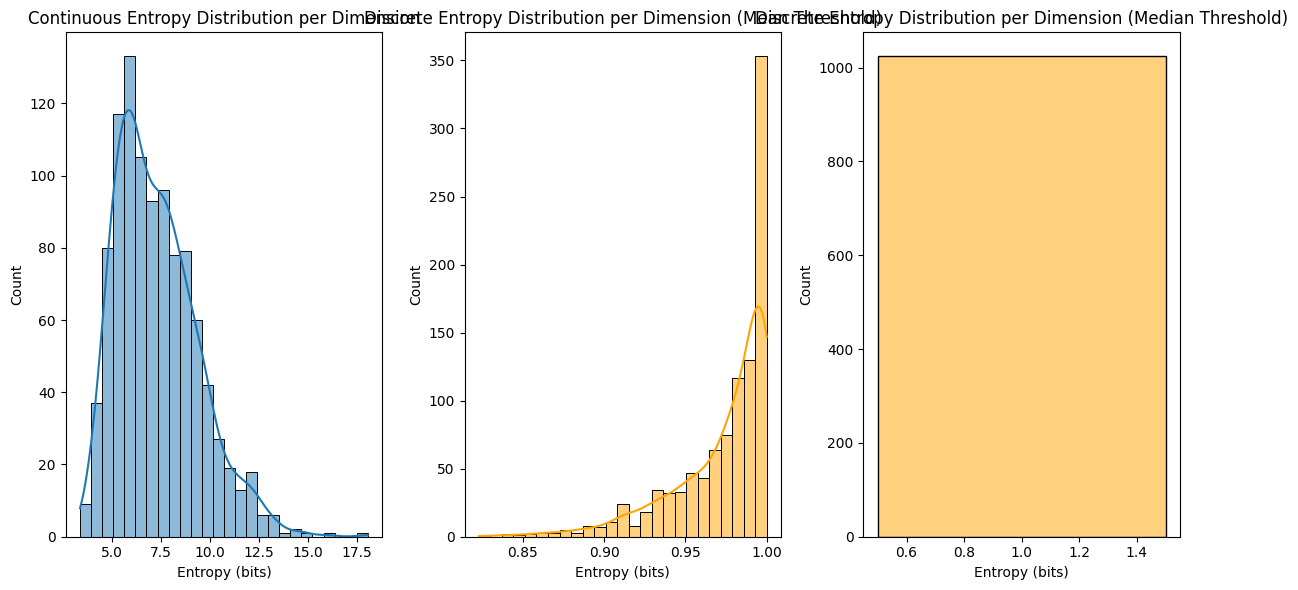

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy

########################################
# Continuous Entropy Estimation
########################################

def continuous_entropy(data, num_bins=50):
    """
    Estimate the continuous entropy of a 1D distribution using a histogram.
    Returns entropy in bits.
    """
    hist, _ = np.histogram(data, bins=num_bins, density=True)
    hist = hist[hist > 0]  # remove empty bins
    cont_entropy = -np.sum(hist * np.log2(hist))
    return cont_entropy

########################################
# Discrete Entropy for Binary Data
########################################

def discrete_binary_entropy(bits):
    """
    Compute discrete entropy for a binary distribution in bits.
    bits: 1D numpy array of 0s and 1s.
    """
    p = np.mean(bits)  # probability of 1
    if p == 0 or p == 1:
        return 0.0
    return - (p * np.log2(p) + (1 - p) * np.log2(1 - p))

########################################
# Compute Continuous Entropy per Dimension
########################################

num_samples, num_dimensions = embeddings.shape
dimension_continuous_entropies = np.zeros(num_dimensions)

for dim in range(num_dimensions):
    dim_data = embeddings[:, dim]
    dimension_continuous_entropies[dim] = continuous_entropy(dim_data, num_bins=50)

########################################
# Compute Mean per Dimension and Binarize Using Mean Threshold
########################################

mean_per_dim = np.mean(embeddings, axis=0)
median_per_dim = np.median(embeddings, axis=0)
binary_embeddings_mean_thresh = (embeddings >= mean_per_dim)
binary_embeddings_median_thresh = (embeddings >= median_per_dim)

dimension_discrete_entropies_mean = np.zeros(num_dimensions)
for dim in range(num_dimensions):
    dim_bits = binary_embeddings_mean_thresh[:, dim].astype(int)
    dimension_discrete_entropies_mean[dim] = discrete_binary_entropy(dim_bits)

dimension_discrete_entropies_median = np.zeros(num_dimensions)
for dim in range(num_dimensions):
    dim_bits = binary_embeddings_median_thresh[:, dim].astype(int)
    dimension_discrete_entropies_median[dim] = discrete_binary_entropy(dim_bits)

########################################
# Compute Averages and Variances
########################################

avg_continuous = np.mean(dimension_continuous_entropies)
var_continuous = np.var(dimension_continuous_entropies)

avg_discrete_med = np.mean(dimension_discrete_entropies_median)
var_discrete_med = np.var(dimension_discrete_entropies_median)
avg_discrete_mean = np.mean(dimension_discrete_entropies_mean)
var_discrete_mean = np.var(dimension_discrete_entropies_mean)

print("Continuous Entropy:")
print("  Mean:", avg_continuous)
print("  Variance:", var_continuous)

print("Discrete Entropy (Mean Threshold):")
print("  Mean:", avg_discrete_mean)
print("  Variance:", var_discrete_mean)

print("Discrete Entropy (Median Threshold):")
print("  Mean:", avg_discrete_med)
print("  Variance:", var_discrete_med)

########################################
# Plot Distributions of Entropies
########################################

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
sns.histplot(dimension_continuous_entropies, kde=True)
plt.title('Continuous Entropy Distribution per Dimension')
plt.xlabel('Entropy (bits)')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
sns.histplot(dimension_discrete_entropies_mean, kde=True, color='orange')
plt.title('Discrete Entropy Distribution per Dimension (Mean Threshold)')
plt.xlabel('Entropy (bits)')
plt.ylabel('Count')


plt.subplot(1, 3, 3)
sns.histplot(dimension_discrete_entropies_median, kde=True, color='orange')
plt.title('Discrete Entropy Distribution per Dimension (Median Threshold)')
plt.xlabel('Entropy (bits)')
plt.ylabel('Count')

plt.tight_layout()

plt.savefig('enthropy.svg')
plt.show()

In [57]:
import numpy as np
import math
from nistrng import pack_sequence, unpack_sequence, check_eligibility_all_battery, run_all_battery, SP800_22R1A_BATTERY

# Assume 'binary_embeddings_mean_thresh' is already computed and available
# from previous steps (mean-thresholding step).
# It's a boolean or int array of shape (num_samples, num_dimensions).

# Flatten to a 1D bit array
bits = binary_embeddings_median_thresh.astype(int).ravel()

# Ensure length is multiple of 8 by padding with zeros if necessary
length = len(bits)
if length % 8 != 0:
    pad_len = 8 - (length % 8)
    bits = np.concatenate([bits, np.zeros(pad_len, dtype=int)])
else:
    pad_len = 0

# Convert every 8 bits into one signed 8-bit integer
num_bytes = len(bits) // 8
sequence = np.zeros(num_bytes, dtype=int)

for i in range(num_bytes):
    # Extract 8 bits
    byte_bits = bits[i*8:(i+1)*8]
    # Convert bits [b0,b1,...,b7] to a number in [0..255]
    # Assume b0 is the most significant bit:
    byte_val = 0
    for bit_idx, bit_val in enumerate(byte_bits):
        byte_val |= (bit_val << (7 - bit_idx))
    # Convert to signed 8-bit range [-128..127]
    if byte_val > 127:
        signed_val = byte_val - 256
    else:
        signed_val = byte_val
    sequence[i] = signed_val

# Pack sequence into binary form
binary_sequence = pack_sequence(sequence)

# Print some info
print("Number of original bits:", length)
print("Number of padded bits:", pad_len)
print("Number of bytes:", num_bytes)
print("Sequence shape:", sequence.shape)
print("First few sequence integers:", sequence[:10])
print("Binary sequence length:", len(binary_sequence))
print("Unpacked check (should match sequence):", unpack_sequence(binary_sequence)[:10])

# Check which tests are eligible from the SP800-22r1a battery
eligible_battery = check_eligibility_all_battery(binary_sequence, SP800_22R1A_BATTERY)

print("Eligible tests from NIST-SP800-22r1a:")
for name in eligible_battery.keys():
    print("- " + name)

# Run all eligible tests
results = run_all_battery(binary_sequence, eligible_battery)

print("Test results:")
for result, elapsed_time in results:
    status = "PASSED" if result.passed else "FAILED"
    print(f"- {status} - score: {np.round(result.score, 3)} - {result.name} - elapsed time: {elapsed_time} ms")

Number of original bits: 409600
Number of padded bits: 0
Number of bytes: 51200
Sequence shape: (51200,)
First few sequence integers: [-21 -10  37  -4  14 -29 -47  92  54  -7]
Binary sequence length: 409600
Unpacked check (should match sequence): [-21 -10  37  -4  14 -29 -47  92  54  -7]
Eligible tests from NIST-SP800-22r1a:
- monobit
- frequency_within_block
- runs
- longest_run_ones_in_a_block
- binary_matrix_rank
- dft
- non_overlapping_template_matching
- maurers_universal
- serial
- approximate_entropy
- cumulative sums
- random_excursion
- random_excursion_variant


/Users/ennucore/Library/Caches/pypoetry/virtualenvs/unclonix-QXL7pPQC-py3.12/lib/python3.12/site-packages/nistrng/sp800_22r1a/test_cumulative_sums.py:55: RuntimeWarning: overflow encountered in scalar absolute
  forward_max = max(abs(forward_sum), forward_max)
/Users/ennucore/Library/Caches/pypoetry/virtualenvs/unclonix-QXL7pPQC-py3.12/lib/python3.12/site-packages/nistrng/sp800_22r1a/test_cumulative_sums.py:56: RuntimeWarning: overflow encountered in scalar absolute
  backward_max = max(abs(backward_sum), backward_max)
/Users/ennucore/Library/Caches/pypoetry/virtualenvs/unclonix-QXL7pPQC-py3.12/lib/python3.12/site-packages/nistrng/sp800_22r1a/test_cumulative_sums.py:53: RuntimeWarning: overflow encountered in scalar add
  forward_sum += bits_copy[i]
/Users/ennucore/Library/Caches/pypoetry/virtualenvs/unclonix-QXL7pPQC-py3.12/lib/python3.12/site-packages/nistrng/sp800_22r1a/test_cumulative_sums.py:54: RuntimeWarning: overflow encountered in scalar add
  backward_sum += bits_copy[bits_co

Test results:
- PASSED - score: 1.0 - Monobit - elapsed time: 0 ms
- PASSED - score: 1.0 - Frequency Within Block - elapsed time: 1 ms
- FAILED - score: 0.0 - Runs - elapsed time: 37 ms
- PASSED - score: 0.528 - Longest Run Ones In A Block - elapsed time: 0 ms
- PASSED - score: 0.446 - Binary Matrix Rank - elapsed time: 314 ms
- FAILED - score: 0.0 - Discrete Fourier Transform - elapsed time: 8 ms
- FAILED - score: 0.0 - Non Overlapping Template Matching - elapsed time: 445 ms
- PASSED - score: 0.02 - Maurers Universal - elapsed time: 120 ms
- FAILED - score: 0.0 - Serial - elapsed time: 5009 ms
- FAILED - score: 0.0 - Approximate Entropy - elapsed time: 2723 ms
- PASSED - score: 1.0 - Cumulative Sums - elapsed time: 123 ms
- FAILED - score: 0.63 - Random Excursion - elapsed time: 728 ms
- FAILED - score: 0.0 - Random Excursion Variant - elapsed time: 2 ms


In [58]:
import numpy as np
import math
from nistrng import pack_sequence, unpack_sequence, check_eligibility_all_battery, run_all_battery, SP800_22R1A_BATTERY

# Assume 'binary_embeddings_mean_thresh' is a boolean or int array of shape (num_samples, num_dimensions).
# Perform NIST tests for each embedding (dimension).

# Function to process each embedding
def run_nist_tests_for_embedding(embedding_bits):
    # Flatten to 1D array and pad to make its length a multiple of 8
    bits = embedding_bits.astype(int).ravel()
    length = len(bits)
    if length % 8 != 0:
        pad_len = 8 - (length % 8)
        bits = np.concatenate([bits, np.zeros(pad_len, dtype=int)])
    else:
        pad_len = 0

    # Convert every 8 bits into one signed 8-bit integer
    num_bytes = len(bits) // 8
    sequence = np.zeros(num_bytes, dtype=int)

    for i in range(num_bytes):
        # Extract 8 bits
        byte_bits = bits[i*8:(i+1)*8]
        # Convert bits [b0, ..., b7] to a number in [0..255]
        byte_val = sum(bit << (7 - bit_idx) for bit_idx, bit in enumerate(byte_bits))
        # Convert to signed 8-bit range [-128..127]
        sequence[i] = byte_val if byte_val <= 127 else byte_val - 256

    # Pack sequence into binary form
    binary_sequence = pack_sequence(sequence)

    # Check eligibility of tests
    eligible_battery = check_eligibility_all_battery(binary_sequence, SP800_22R1A_BATTERY)

    # Run all eligible tests
    results = run_all_battery(binary_sequence, eligible_battery)

    # Return test results
    return results, eligible_battery

# Main processing
def evaluate_embeddings(binary_embeddings_mean_thresh):
    num_samples = binary_embeddings_mean_thresh.shape[0]
    pass_fail_counts = []
    pass_fail_by_test = {}
    all_scores = {}

    for sample_idx in range(num_samples):
        embedding_bits = binary_embeddings_mean_thresh[sample_idx]

        # Run NIST tests for this embedding
        results, eligible_battery = run_nist_tests_for_embedding(embedding_bits)

        # Analyze results
        passed = 0
        total = len(results)
        for result, elapsed_time in results:
            if result.name not in all_scores:
                all_scores[result.name] = []
            all_scores[result.name].append(result.score)
            pass_fail_by_test[result.name] = pass_fail_by_test.get(result.name, 0) + result.passed
            if result.passed:
                passed += 1

        # Record pass percentage
        pass_fail_counts.append(passed / total if total > 0 else 0)

    # Compute overall pass percentage and average scores
    pass_percentage = np.mean(pass_fail_counts) * 100
    avg_scores = {test: np.mean(scores) for test, scores in all_scores.items()}

    return pass_percentage, avg_scores, pass_fail_counts, pass_fail_by_test

pass_percentage, avg_scores, pass_fail_counts, pass_fail_by_test = evaluate_embeddings(binary_embeddings_median_thresh)

# Print results
print(f"Overall Pass Percentage: {pass_percentage:.2f}%")
print("Average Scores for Each Test:")
for test, avg_score in avg_scores.items():
    print(f"- {test}: {avg_score:.3f}")
print("Pass % by test:")
for test, pass_n in pass_fail_by_test.items():
    print(f"- {test}: {pass_n / len(binary_embeddings_median_thresh) * 100:.1f}% passed")
print("Pass/Fail Percentages for Individual Embeddings:")

Overall Pass Percentage: 85.64%
Average Scores for Each Test:
- Monobit: 0.638
- Frequency Within Block: 0.273
- Runs: 0.493
- Longest Run Ones In A Block: 0.252
- Discrete Fourier Transform: 0.444
- Non Overlapping Template Matching: 0.760
- Serial: 0.504
- Approximate Entropy: 0.438
- Cumulative Sums: 0.526
- Random Excursion: 0.170
- Random Excursion Variant: 0.568
Pass % by test:
- Monobit: 100.0% passed
- Frequency Within Block: 98.5% passed
- Runs: 99.5% passed
- Longest Run Ones In A Block: 92.8% passed
- Discrete Fourier Transform: 97.2% passed
- Non Overlapping Template Matching: 96.0% passed
- Serial: 99.5% passed
- Approximate Entropy: 97.8% passed
- Cumulative Sums: 100.0% passed
- Random Excursion: 0.2% passed
- Random Excursion Variant: 60.5% passed
Pass/Fail Percentages for Individual Embeddings:


In [59]:
len(binary_embeddings_median_thresh)

400

/var/folders/1x/t909rs3x6rx12g06tz4zy9740000gn/T/ipykernel_31252/3110070971.py:43: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  X_new = torch.Tensor([augment_spectrum(sp) for sp in new_spectra]).to(device)


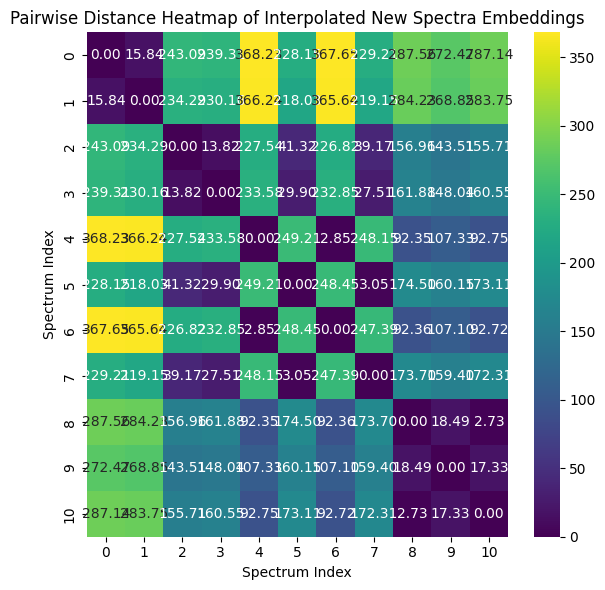

In [60]:
import numpy as np
import glob
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance

# Load the reference x-axis from xxx.txt
reference_file = "xxx.txt"
x_ref = eval(open(reference_file).read())
# Ensure x_ref is sorted (if not already)
if not np.all(np.diff(x_ref) > 0):
    sort_idx = np.argsort(x_ref)
    x_ref = x_ref[sort_idx]

# Load spectra from input/*.txt
files = glob.glob('inputs/*.txt')
new_spectra = []

for f in files:
    if f == reference_file:
        # Skip the reference file if it's also in input/
        continue
    data = np.loadtxt(f)
    x = data[:,0]
    y = data[:,1]

    # Ensure x is sorted for interpolation
    if not np.all(np.diff(x) > 0):
        sort_idx = np.argsort(x)
        x = x[sort_idx]
        y = y[sort_idx]

    # Interpolate the y-values onto the reference x-axis
    # np.interp assumes x is increasing
    y_interp = np.interp(x_ref, x, y)
    new_spectra.append(y_interp)

new_spectra = np.array(new_spectra)  # shape: (num_files, len(x_ref))
new_spectra = new_spectra * float((new_spectra.shape[0] / new_spectra.sum() * X_test[:, :2048].sum() / X_test.shape[0]).cpu())

# From here you can apply the same post-processing and embedding steps as before
X_new = torch.Tensor([augment_spectrum(sp) for sp in new_spectra]).to(device)

model.eval()
with torch.no_grad():
    embeddings_new = model.forward_one(X_new).cpu().numpy()

# Compute pairwise distances
pairwise_distances = distance.squareform(distance.pdist(embeddings_new, 'euclidean'))

# Plot heatmap
plt.figure(figsize=(6,6))
sns.heatmap(pairwise_distances, cmap='viridis', annot=True, fmt=".2f")
plt.title('Pairwise Distance Heatmap of Interpolated New Spectra Embeddings')
plt.xlabel('Spectrum Index')
plt.ylabel('Spectrum Index')
plt.tight_layout()
plt.savefig('figures/polarizations_confusion_matrix.svg')
plt.show()

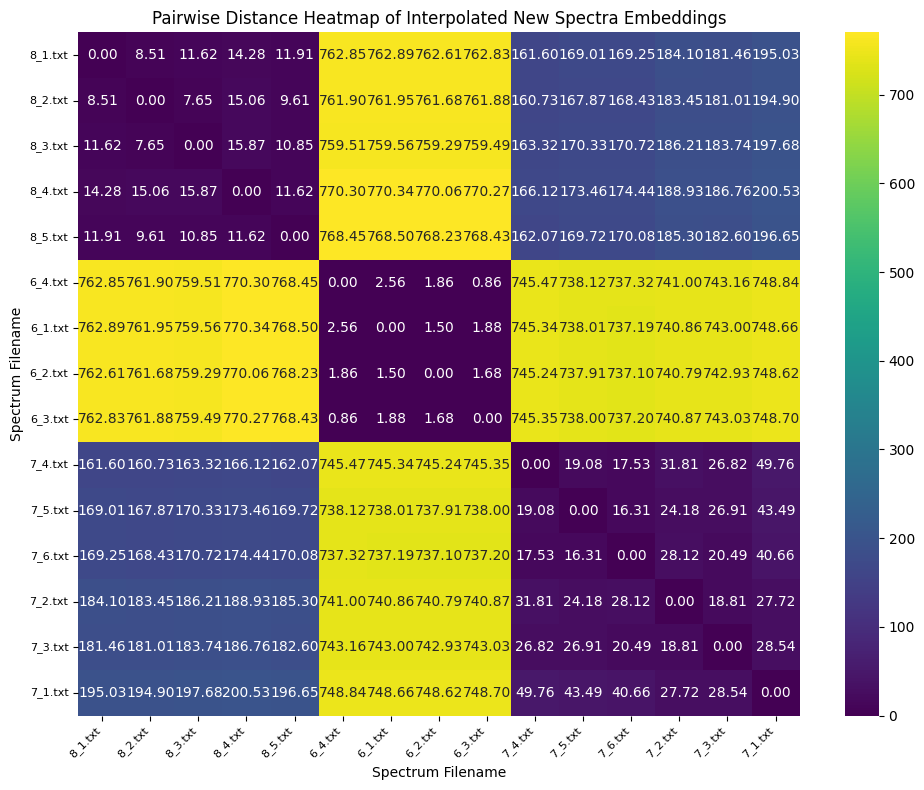

In [63]:
import os  # Import to handle file path operations

# Load the reference x-axis from xxx.txt
reference_file = "xxx.txt"
x_ref = eval(open(reference_file).read())
# Ensure x_ref is sorted (if not already)
if not np.all(np.diff(x_ref) > 0):
    sort_idx = np.argsort(x_ref)
    x_ref = x_ref[sort_idx]

# Load spectra from input/*.txt
files = glob.glob('inputs/*.txt')
new_spectra = []
file_labels = []  # List to store file labels for heatmap

for f in files:
    if f == reference_file:
        # Skip the reference file if it's also in input/
        continue
    file_labels.append(os.path.basename(f))  # Extract the filename as a label
    data = np.loadtxt(f)
    x = data[:,0]
    y = data[:,1]

    # Ensure x is sorted for interpolation
    if not np.all(np.diff(x) > 0):
        sort_idx = np.argsort(x)
        x = x[sort_idx]
        y = y[sort_idx]

    # Interpolate the y-values onto the reference x-axis
    # np.interp assumes x is increasing
    y_interp = np.interp(x_ref, x, y)
    new_spectra.append(y_interp)

new_spectra = np.array(new_spectra)  # shape: (num_files, len(x_ref))
new_spectra = new_spectra * float((new_spectra.shape[0] / new_spectra.sum() * X_test[:, :2048].sum() / X_test.shape[0]).cpu())

# From here you can apply the same post-processing and embedding steps as before
X_new = torch.Tensor([augment_spectrum(sp) for sp in new_spectra]).to(device)

model.eval()
with torch.no_grad():
    embeddings_new = model.forward_one(X_new).cpu().numpy()

# Compute pairwise distances
pairwise_distances = distance.squareform(distance.pdist(embeddings_new, 'euclidean'))

# Plot heatmap with filenames as labels
plt.figure(figsize=(10, 8))  # Adjust size to accommodate labels
sns.heatmap(pairwise_distances, cmap='viridis', annot=True, fmt=".2f",
            xticklabels=file_labels, yticklabels=file_labels)
plt.xticks(rotation=45, ha='right', fontsize=8)  # Rotate x-axis labels for better visibility
plt.yticks(fontsize=8)  # Adjust y-axis label font size
plt.title('Pairwise Distance Heatmap of Interpolated New Spectra Embeddings')
plt.xlabel('Spectrum Filename')
plt.ylabel('Spectrum Filename')
plt.tight_layout()
plt.savefig('figures/numbers_confusion_matrix.svg')
plt.show()


In [62]:
new_spectra.sum()

np.float64(2026696.9641117328)